<a href="https://colab.research.google.com/github/Marlianur09/Tugas_Praktikum_023_043/blob/main/Kegiatan_Modul_4_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [151]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import random

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [152]:
train = pd.read_csv('aptos2019-blindness-detection/train.csv')
test = pd.read_csv('aptos2019-blindness-detection/test.csv')
submission= pd.read_csv('aptos2019-blindness-detection/sample_submission.csv')
train_dir = 'aptos2019-blindness-detection/train_images'
train1 = pd.read_csv('aptos2019-blindness-detection/train.csv')

In [153]:
print('Number of train samples: ', train.shape[0])
print('Number of test samples: ', test.shape[0])
display(train.head())

Number of train samples:  3662
Number of test samples:  1928


,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [ ]:
!pip install opencv-python

In [ ]:
!pip install seaborn

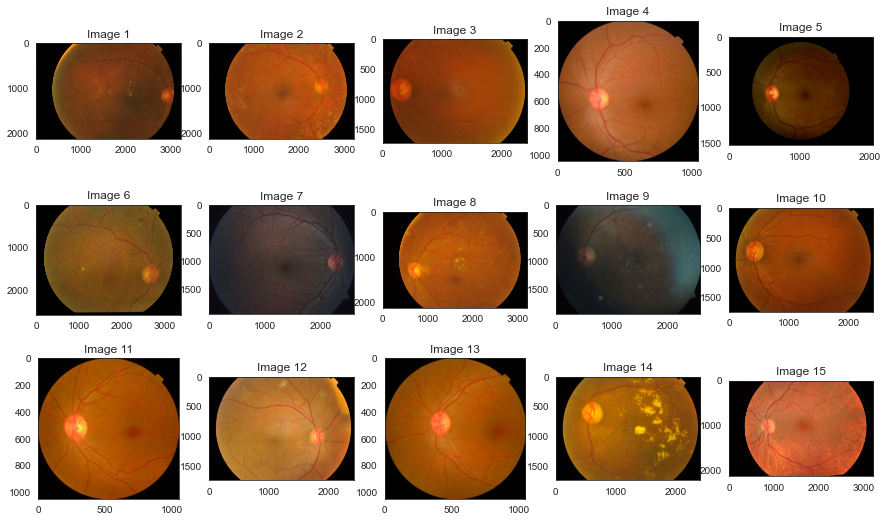

In [154]:
import seaborn as sns
import cv2
sns.set_style("white")
count = 1
plt.figure(figsize=[15, 15])
for img_name in train['id_code'][:15]:
    img = cv2.imread("aptos2019-blindness-detection/train_images/%s.png" % img_name)[...,[2, 1, 0]]
    plt.subplot(5, 5, count)
    plt.imshow(img)
    plt.title("Image %s" % count)
    count += 1
    
plt.show()

In [155]:
train["id_code"] = train["id_code"].apply(lambda x: x + ".png")
test["id_code"] = test["id_code"].apply(lambda x: x + ".png")
train['diagnosis'] = train['diagnosis'].astype('str')
train.head()

,id_code,diagnosis
0,000c1434d8d7.png,2
1,001639a390f0.png,4
2,0024cdab0c1e.png,1
3,002c21358ce6.png,0
4,005b95c28852.png,0


In [156]:
train_datagen=ImageDataGenerator(rescale=1./255, 
                                 validation_split=0.2,
                                 horizontal_flip=True)

train_generator=train_datagen.flow_from_dataframe(
    dataframe=train,
    directory="aptos2019-blindness-detection/train_images/",
    x_col="id_code",
    y_col="diagnosis",
    batch_size=16,
    class_mode="categorical",
    target_size=(128, 128),
    subset='training',
    color_mode='rgb')

Found 2930 validated image filenames belonging to 5 classes.


In [157]:
valid_generator=train_datagen.flow_from_dataframe(
    dataframe=train,
    directory="aptos2019-blindness-detection/train_images/",
    x_col="id_code",
    y_col="diagnosis",
    batch_size=16,
    class_mode="categorical",    
    target_size=(128, 128),
    subset='validation',
    color_mode='rgb')

Found 732 validated image filenames belonging to 5 classes.


In [158]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(  
        dataframe=test,
        directory = "aptos2019-blindness-detection/test_images/",
        x_col="id_code",
        target_size=(128, 128),
        batch_size=16,
        shuffle=False,
        class_mode=None)

Found 1928 validated image filenames.


In [159]:
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp

In [160]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [161]:
!rm -rf ./logs/ 

In [184]:
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([128]))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.2, 0.5))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam','adadelta']))

METRIC_ACCURACY = 'accuracy'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_NUM_UNITS, HP_DROPOUT, HP_OPTIMIZER],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
  )

In [185]:
xvl, yvl = zip(*(valid_generator[i] for i in range(len(valid_generator))))
x_val, y_val = np.vstack(xvl), np.vstack(yvl)

In [192]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.layers import InputLayer, Activation, Dense, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization
from tensorflow.keras.models import Sequential

def train_test_model(hparams):
  model = Sequential()

  model.add(InputLayer(input_shape=[128,128,3]))

  model.add(Conv2D(filters=128, kernel_size=7, strides=7, padding='same', activation='relu'))
  model.add(Dropout(hparams[HP_DROPOUT]))

  model.add(Conv2D(filters=128, kernel_size=3, strides=3, padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=2, padding='same'))
  model.add(Dropout(hparams[HP_DROPOUT]))

  model.add(Conv2D(filters=128, kernel_size=3, strides=3, padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(hparams[HP_DROPOUT]))

  model.add(Flatten())

  # Fully Connected Layer
  model.add(Dense(hparams[HP_NUM_UNITS], activation='relu'))
  model.add(Dropout(hparams[HP_DROPOUT]))
  model.add(Dense(5, activation='softmax'))
  
  model.compile(
      optimizer=hparams[HP_OPTIMIZER],
      loss='categorical_crossentropy',
      metrics=['accuracy'],
  )
 
  # model.fit(x_train, y_train, epochs=10) 
  model.fit(train_generator, 
            validation_data=valid_generator, 
            epochs=25,
            )
  _, accuracy = model.evaluate(x_val, y_val)
  return accuracy

In [193]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size

In [194]:
def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # record the values used in this trial
    accuracy = train_test_model(hparams)
    tf.summary.scalar(METRIC_ACCURACY, accuracy, step=100)

In [195]:
['adam', 'sgd', 'adadelta', 'rmsprop', 'adamx', 'nadam']

['adam', 'sgd', 'adadelta', 'rmsprop', 'adamx', 'nadam']

In [196]:
session_num = 0

for num_units in HP_NUM_UNITS.domain.values:
  for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
    for optimizer in HP_OPTIMIZER.domain.values:
      hparams = {
          HP_NUM_UNITS: num_units,
          HP_DROPOUT: dropout_rate,
          HP_OPTIMIZER: optimizer,
      }
      run_name = "run-%d" % session_num
      print('--- Starting trial: %s' % run_name)
      print({h.name: hparams[h] for h in hparams})
      run('logs/hparam_tuning/' + run_name, hparams)
      session_num += 1


--- Starting trial: run-0
{'num_units': 128, 'dropout': 0.2, 'optimizer': 'adadelta'}
Epoch 1/25
184/184 [==============================] - 313s 2s/step - loss: 3.6946 - accuracy: 0.0993 - val_loss: 1.7663 - val_accuracy: 0.1052
Epoch 2/25
184/184 [==============================] - 317s 2s/step - loss: 2.9609 - accuracy: 0.1184 - val_loss: 1.7655 - val_accuracy: 0.1025
Epoch 3/25
184/184 [==============================] - 311s 2s/step - loss: 2.5442 - accuracy: 0.1392 - val_loss: 1.5971 - val_accuracy: 0.2937
Epoch 4/25
184/184 [==============================] - 321s 2s/step - loss: 2.2492 - accuracy: 0.1638 - val_loss: 1.4477 - val_accuracy: 0.4208
Epoch 5/25
184/184 [==============================] - 302s 2s/step - loss: 1.9788 - accuracy: 0.2235 - val_loss: 1.3524 - val_accuracy: 0.4877
Epoch 6/25
184/184 [==============================] - 308s 2s/step - loss: 1.8285 - accuracy: 0.2696 - val_loss: 1.2862 - val_accuracy: 0.5096
Epoch 7/25
184/184 [==============================] - 30

In [200]:
import opendatasets as od

In [201]:
od.download("https://storage.googleapis.com/download.tensorflow.org/tensorboard/hparams_demo_logs.zip")

Using downloaded and verified file: .\hparams_demo_logs.zip


In [229]:
%%bash

!unzip -q hparams_demo_logs.zip -d logs/hparam_demo

-bash: line 2: !unzip: command not found


CalledProcessError: ignored

In [227]:
!unzip -q hparams_demo_logs.zip -d logs/hparam_demo

^C


In [231]:
%tensorboard --logdir logs/hparam_tuning

Reusing TensorBoard on port 6006 (pid 10864), started 1:03:35 ago. (Use '!kill 10864' to kill it.)

In [234]:
model = train_test_model(hparams)

Epoch 1/25
184/184 [==============================] - 311s 2s/step - loss: 1.4563 - accuracy: 0.4932 - val_loss: 1.3876 - val_accuracy: 0.5970
Epoch 2/25
184/184 [==============================] - 310s 2s/step - loss: 1.0766 - accuracy: 0.6143 - val_loss: 1.0118 - val_accuracy: 0.6366
Epoch 3/25
184/184 [==============================] - 302s 2s/step - loss: 0.9815 - accuracy: 0.6485 - val_loss: 0.8774 - val_accuracy: 0.6926
Epoch 4/25
184/184 [==============================] - 313s 2s/step - loss: 0.9312 - accuracy: 0.6843 - val_loss: 0.8704 - val_accuracy: 0.6926
Epoch 5/25
184/184 [==============================] - 314s 2s/step - loss: 0.8906 - accuracy: 0.7014 - val_loss: 0.8390 - val_accuracy: 0.6995
Epoch 6/25
184/184 [==============================] - 617s 3s/step - loss: 0.8667 - accuracy: 0.7092 - val_loss: 0.8071 - val_accuracy: 0.7036
Epoch 7/25
184/184 [==============================] - 388s 2s/step - loss: 0.8623 - accuracy: 0.7137 - val_loss: 0.7842 - val_accuracy: 0.7104